## Airbnb Price Prediction

#### GOAL
The proposed AI-driven price prediction model aims to surpass existing solutions by integrating additional features and factors that are currently underutilized. This leads to better pricing recommendation to hosts, which removes the need for hosts to rely on third-party software and allows airbnb to retain the costs for dynamic pricing.

#### TOOLS USED
<ol>
    <li>Numpy</li>
    <li>Pandas</li>
    <li>Matplotlib</li>
    <li>Seaborn</li>
    <li>Scikit-learn</li>
    <li>NLTK</li>
</ol>

#### Process
<ol>
    <li>Data Ingestion</li>
    <li>Data Preprocessing</li>
    <ul>
        <li>Initial Feature Elimination</li>
        <li>Handling Missing Values</li>
    </ul>
    <li>Feature Engineering</li>
    <ul>
        <li>Data Encoding</li>
        <li>Sentiment Scores</li>
    </ul>
    <li>Data Preparation</li>
    <ul>
        <li>Outlier Elimination</li>
        <li>Feature Selection</li>
        <li>PCA</li>
    </ul>
    <li>Model Building and Evaluation
</ol>

### Data Ingestion

In [100]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from scipy import stats
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import re
# import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from numpy import logspace
import lightgbm as lgb
import xgboost as xgb
from sklearn import ensemble
import warnings
warnings.filterwarnings('ignore')

In [101]:
# Loading airbnb data of 8 cities
montreal = pd.read_csv('Dataset/Airbnb/Montreal.csv')
newbrunswick = pd.read_csv('Dataset/Airbnb/NewBrunswick.csv')
ottawa = pd.read_csv('Dataset/Airbnb/Ottawa.csv')
quebeccity = pd.read_csv('Dataset/Airbnb/QuebecCity.csv')
toronto = pd.read_csv('Dataset/Airbnb/Toronto.csv')
vancouver = pd.read_csv('Dataset/Airbnb/Vancouver.csv')
victoria = pd.read_csv('Dataset/Airbnb/Victoria.csv')
winnipeg = pd.read_csv('Dataset/Airbnb/Winnipeg.csv')


# Adding a City column to each dataframes
montreal['city'] = 'Montreal'
newbrunswick['city'] = 'New Brunswick'
ottawa['city'] = 'Ottawa'
quebeccity['city'] = 'Quebec City'
toronto['city'] = 'Toronto'
vancouver['city'] = 'Vancouver'
victoria['city'] = 'Victoria'
winnipeg['city'] = 'Winnipeg'

# Merging data from different cities to a single dataframe
airbnb_df = pd.concat([montreal, newbrunswick, ottawa, quebeccity, toronto, vancouver, victoria, winnipeg], ignore_index=True)

Review sentiment scores were calculated separately since they take a very long time due to high size of textual data. They were calculated and aggregated for each listing, and saved into a separate csv file which we will load and merge to our airbnb dataset. This will be made dynamic during the demo and deployment of the model.

In [102]:
# Loading the review sentiment scores
reviews_df = pd.read_csv('Dataset/Sentiment/listing_sentiment_scores.csv')

airbnb_df = pd.merge(airbnb_df, reviews_df, left_on='id', right_on='listing_id', how='left')

In [103]:
# Checking the data size
print("\nThe data size is : {} ".format(airbnb_df.shape))


The data size is : (49636, 78) 


In [104]:
# Checking dataset information
print(airbnb_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            49636 non-null  int64  
 1   listing_url                                   49636 non-null  object 
 2   scrape_id                                     49636 non-null  int64  
 3   last_scraped                                  49636 non-null  object 
 4   source                                        49636 non-null  object 
 5   name                                          49636 non-null  object 
 6   description                                   48752 non-null  object 
 7   neighborhood_overview                         27492 non-null  object 
 8   picture_url                                   49636 non-null  object 
 9   host_id                                       49636 non-null 

In [105]:
# Checking what the data looks like
airbnb_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,listing_id,sentiment_score
0,29059,https://www.airbnb.com/rooms/29059,20240323015116,2024-03-23,city scrape,Lovely studio Quartier Latin,CITQ 267153<br />Lovely studio with 1 closed r...,NaN,https://a0.muscache.com/pictures/736399/fa6c31...,125031,...,"267153, expires: 2024-03-31",f,2,2,0,0,2.69,Montreal,29059.0,0.70
1,29061,https://www.airbnb.com/rooms/29061,20240323015116,2024-03-23,city scrape,Maison historique - Quartier Latin,Lovely historic house with plenty of period ch...,NaN,https://a0.muscache.com/pictures/9e59d417-4b6a...,125031,...,"267153, expires: 2024-03-31",f,2,2,0,0,0.88,Montreal,29061.0,0.70
2,36301,https://www.airbnb.com/rooms/36301,20240323015116,2024-03-23,city scrape,Romantic & peaceful Plateau loft,"Enjoy the best of Montreal in this romantic, ...",The neighborhood is very lively while the stre...,https://a0.muscache.com/pictures/26c20544-475f...,381468,...,NaN,f,3,3,0,0,0.47,Montreal,36301.0,0.78
3,38118,https://www.airbnb.com/rooms/38118,20240323015116,2024-03-23,city scrape,Beautiful room with a balcony in front of a parc,Nearest metro Papineau.,NaN,https://a0.muscache.com/pictures/213997/763ec1...,163569,...,NaN,f,1,0,1,0,0.10,Montreal,38118.0,0.73
4,50479,https://www.airbnb.com/rooms/50479,20240323015116,2024-03-23,city scrape,L'Arcade Douce,The appartement is sunny and ideally situated ...,Our area is full of life (but our street is qu...,https://a0.muscache.com/pictures/miso/Hosting-...,231694,...,"271530, expires: 2024-04-30",t,2,1,1,0,1.60,Montreal,50479.0,0.65


In [106]:
# Checking for null values in the dataset
airbnb_df.isnull().sum().sort_values(ascending=False)

calendar_updated                49636
neighbourhood_group_cleansed    41746
host_neighbourhood              28125
license                         27612
host_about                      25466
                                ...  
minimum_maximum_nights              0
maximum_maximum_nights              0
minimum_nights_avg_ntm              0
maximum_nights_avg_ntm              0
amenities                           0
Length: 78, dtype: int64

### Initial Feature Elimination

First, we manually eliminated some features that were unnecessary. The features removed were listing_url, scrape_id, last_scraped, source, host_url, host_thumbnail_url, host_picture_url, calendar_updated, and calendar_last_scraped.

In [107]:
airbnb_df = airbnb_df.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'source', 'host_url', 'host_thumbnail_url', 'calendar_updated', 'calendar_last_scraped', 'host_name', 'listing_id', 'host_id'], axis=1)

Secondly, we eliminate many location-related and listing count related columns since many of them are duplicated, and are mostly filled with null values.

In [108]:
airbnb_df = airbnb_df.drop(columns=['neighbourhood_group_cleansed', 'host_neighbourhood', 'host_location', 'neighbourhood', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'review_scores_accuracy'], axis=1)

Thirdly, we eliminate redundant columns.

In [109]:
airbnb_df = airbnb_df.drop(columns=['bathrooms_text', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'number_of_reviews_ltm', 'number_of_reviews_l30d'], axis=1)

Finally, eliminating host about and neighbourhood about because of language challenges.

In [110]:
airbnb_df = airbnb_df.drop(columns=['host_about', 'neighborhood_overview'], axis=1)

### Renaming Columns

In [111]:
# Mapping new column names
column_mappings = {
    'name': 'title',
    'first_review': 'first_review_date',
    'last_review': 'last_review_date',
    'review_scores_value': 'review_scores_value_for_money',
    'calculated_host_listings_count': 'host_listings_count',
    'neighbourhood_cleansed': 'neighbourhood',
    'sentiment_score': 'review_sentiment_score'
}

# Renaming columns
airbnb_df.rename(columns=column_mappings, inplace=True)

### EDA

Map of number of listings in Canada

In [112]:
# Creating a map centered around New Brunswick
center_lat = 46.5653
center_lon = -66.4619
m = folium.Map(location=[center_lat, center_lon], zoom_start=7)

# Adding red dots for each location
for _, row in airbnb_df.sample(1000).iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.Icon(color='blue', icon='cloud')
    ).add_to(m)

# Displaying the map
m

### Train-Test Split

In [113]:
data_train, data_test = train_test_split(airbnb_df, test_size=0.2, random_state=42)

In [114]:
# Checking the data size
print("\nThe train data size is : {} ".format(data_train.shape))
print("The test data size is : {} ".format(data_test.shape))


The train data size is : (39708, 45) 
The test data size is : (9928, 45) 


### Data Preprocessing

In [115]:
# Removing "$" from price and converting to float
data_train['price'] = data_train['price'].str.replace('[$,]', '', regex=True).astype(float)

In [116]:
# Checking what the data looks like
data_train.head()

,id,title,description,picture_url,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value_for_money,license,instant_bookable,host_listings_count,city,review_sentiment_score
45298,42795518,Guest Suites on Benvenuto ( Loft ),Welcome to Guest Suites on Benvenuto. This cha...,https://a0.muscache.com/pictures/46c82a2d-1271...,2020-03-01,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/3dc27...,...,4.61,4.78,4.78,4.70,4.70,NaN,t,3,Victoria,0.75
15387,43787349,101 - Lofts St-Joseph - Par Les Lofts Vieux-QC,Located in a freshly renovated 1918 building w...,https://a0.muscache.com/pictures/406d92f6-0400...,2014-11-13,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/aaa62...,...,4.88,4.77,4.65,4.85,4.50,"280486, expires: 2025-01-31",f,67,Quebec City,0.43
27145,631273302231126353,Tony202欢乐之屋,Tony202 Happy House is located on the second f...,https://a0.muscache.com/pictures/9a972421-a043...,2020-01-17,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/User-...,...,4.82,5.00,4.86,4.64,4.82,STR-2011-HDCKVJ,f,6,Toronto,0.53
4932,826839104993333000,Appartement dans Rosemont,Newly renovated 3 bedroom apartment located in...,https://a0.muscache.com/pictures/miso/Hosting-...,2022-03-29,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/38354...,...,4.98,4.93,4.93,4.88,4.80,"313083, expires: 2024-04-25",f,1,Montreal,0.68
280,4100405,Chic et deco moderne au coeur du Rosemont,Luxurious sunny apartment in a typical Montrea...,https://a0.muscache.com/pictures/091ed9d0-bd7f...,2013-07-06,within an hour,100%,96%,t,https://a0.muscache.com/im/pictures/user/c2585...,...,5.00,5.00,5.00,4.63,4.88,NaN,f,7,Montreal,0.49


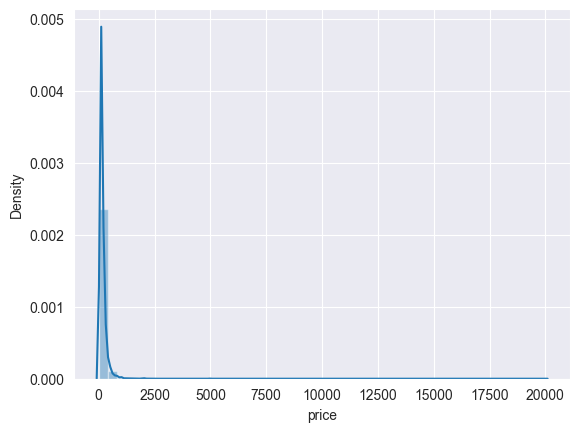

In [117]:
# Plotting a histogram of target variable
sns.distplot(data_train['price']);

The prices for the listings in the dataset are greatly skewed to the right as shown above. This causes a non-linear relationship between the price and features.

To solve this issue, we take the natural logarithm of the price to make the effective relationship non-linear, while still preserving the linear model. This will be very important when testing different regression models. The results of this are shown below.

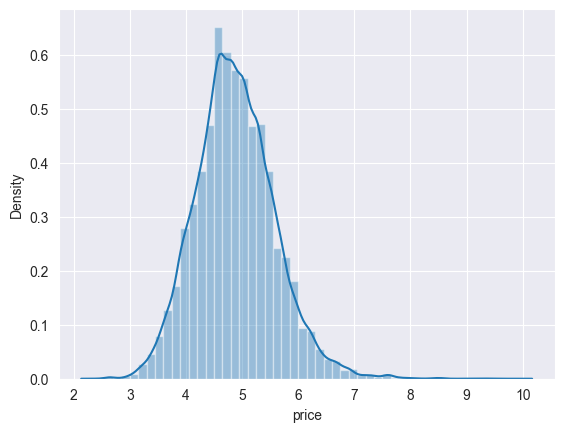

In [118]:
# Converting values in price column to its natural logarithm
data_train['price'] = np.log(data_train['price'])

# Plotting a histogram of the log of price
sns.distplot(data_train['price']);

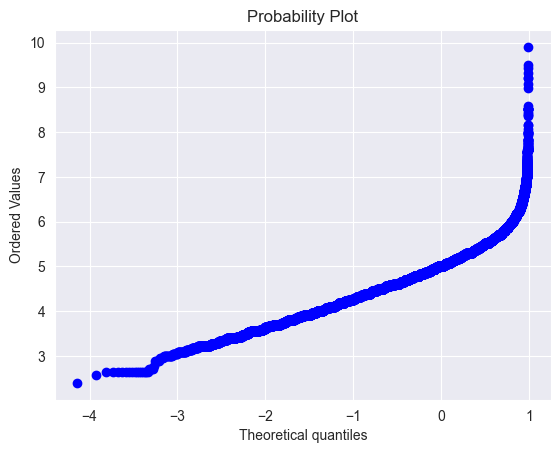

In [119]:
# The QQ-plot
fig = plt.figure()
res = stats.probplot(data_train['price'], plot=plt)
plt.show()

In [120]:
# Identify and drop non-numeric columns
non_numeric_columns = data_train.select_dtypes(include=['object']).columns
data_train_numeric = data_train.drop(non_numeric_columns, axis=1)

corr_mx = data_train_numeric.corr()
corr_mx["price"].sort_values(ascending=False)

price                            1.000000
accommodates                     0.573653
bedrooms                         0.501244
beds                             0.418264
bathrooms                        0.383542
review_sentiment_score           0.268507
review_scores_location           0.183958
review_scores_cleanliness        0.153046
review_scores_rating             0.143971
review_scores_value_for_money    0.099679
review_scores_communication      0.096142
availability_30                  0.075790
latitude                         0.069862
review_scores_checkin            0.055787
availability_60                  0.043660
availability_90                  0.021232
number_of_reviews                0.019199
maximum_nights                   0.009860
availability_365                -0.005453
id                              -0.033275
host_listings_count             -0.100028
minimum_nights                  -0.117536
longitude                       -0.168249
Name: price, dtype: float64

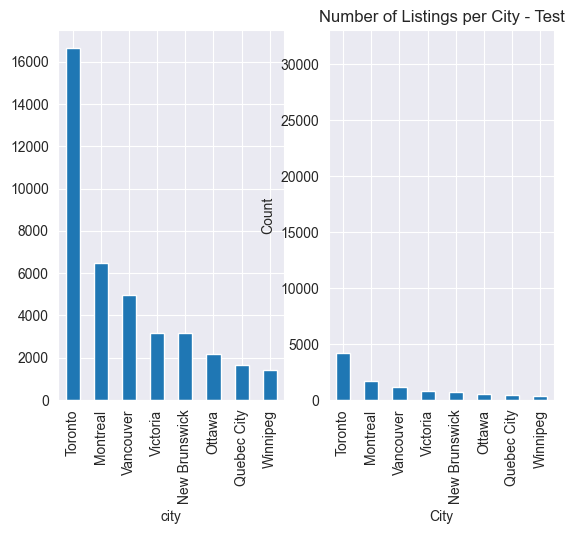

In [121]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

data_train['city'].value_counts().plot(kind='bar', ax=ax1)
plt.title('Number of Listings per City - Train')
plt.xlabel('City')
plt.ylabel('Count')


data_test['city'].value_counts().plot(kind='bar', ax=ax2)
plt.title('Number of Listings per City - Test')
plt.xlabel('City')
plt.ylabel('Count')
plt.ylim(0,33000 )
plt.show()

The ratio between listings in each city in Train set vs Test set seem to be similar, which is good!

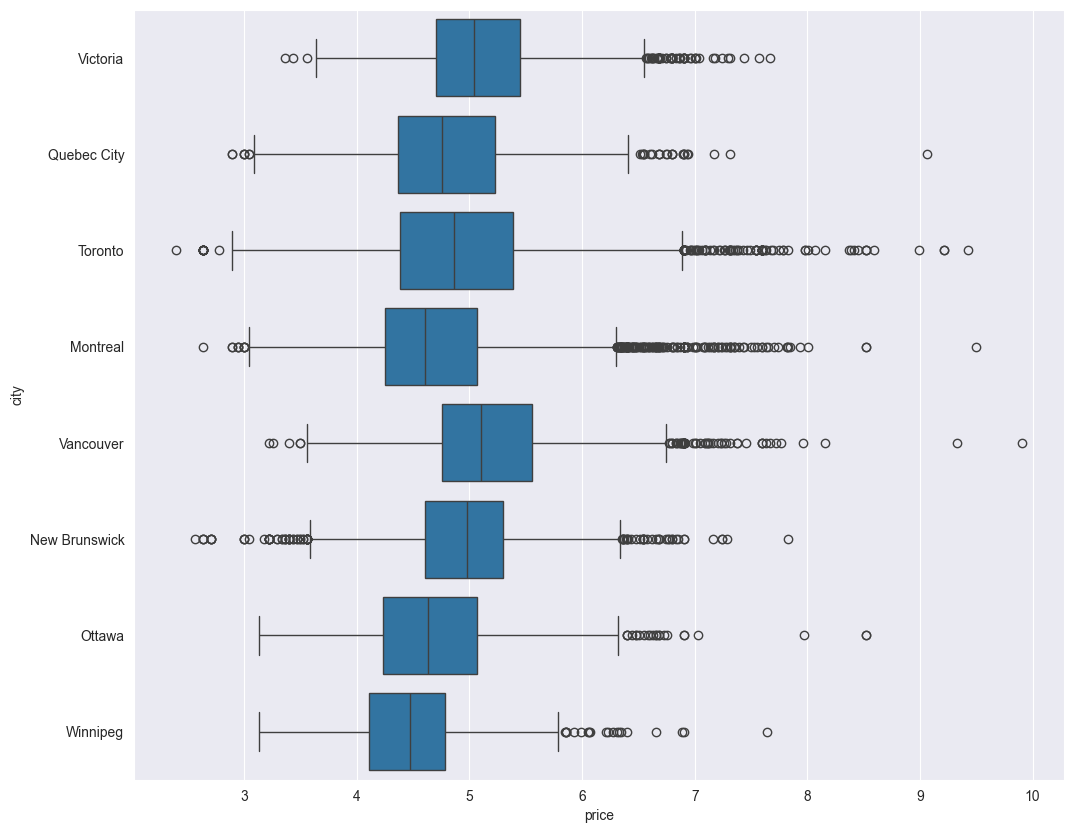

In [122]:
NEIdata = data_train.copy()
plt.figure(figsize = (12, 10))
sns.boxplot(y = 'city', x = 'price',  data = NEIdata, orient="h")
xt = plt.xticks()

### Handling Missing Values

In [123]:
# Checking for null values in the dataset
data_train.isnull().sum().sort_values(ascending=False)

license                          22120
review_sentiment_score            9571
host_response_time                8300
host_response_rate                8300
review_scores_value_for_money     8232
review_scores_location            8232
review_scores_communication       8231
review_scores_checkin             8231
review_scores_cleanliness         8230
first_review_date                 8193
last_review_date                  8193
review_scores_rating              8191
host_acceptance_rate              6557
beds                              6422
price                             6420
bathrooms                         6389
bedrooms                          1668
has_availability                  1107
description                        719
host_is_superhost                  432
host_identity_verified               2
host_has_profile_pic                 2
host_verifications                   2
host_picture_url                     2
host_since                           2
city                     

The null in license column means that the listing doesn't have any license, so filled the column with said information.

In [124]:
# Fill null value with unlicensed
data_train['license'].fillna('Unlicensed', inplace=True)

Dropping all rows that don't have price because it doesn't help the model if it is filled in any way to make correct predictions

In [125]:
# Drop rows with empty price
data_train = data_train.dropna(subset=['price'])

It makes more sense to fill null values in review ratings with 0 when the review count is 0. This logically represents the absence of reviews and avoids introducing potential bias by assuming that these listings would have median ratings.

In [126]:
# Fill null values with 0 for specified columns where 'number_of_reviews' equals 0
columns_to_fill = [
    'review_scores_value_for_money',
    'review_scores_location',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_cleanliness',
    'review_scores_rating'
]

for column in columns_to_fill:
    data_train.loc[data_train['number_of_reviews'] == 0, column] = 0

Filling all null values in review_sentiment_score to 0 as no review content is neutral

In [127]:
data_train['review_sentiment_score'].fillna(0, inplace=True)

Similarly, filling null values in first and last review dates with today's date where review count is 0. This will be important during data encoding.

In [128]:
# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

# Fill null values with today's date where 'number_of_reviews' equals 0
data_train.loc[data_train['number_of_reviews'] == 0, 'first_review_date'] = data_train.loc[data_train['number_of_reviews'] == 0, 'first_review_date'].fillna(today_date)
data_train.loc[data_train['number_of_reviews'] == 0, 'last_review_date'] = data_train.loc[data_train['number_of_reviews'] == 0, 'last_review_date'].fillna(today_date)

Filling null values in host_is_superhost and 'availability' with "f" since the missing values are not random, and just corresponds to none.

In [129]:
data_train['host_is_superhost'] = data_train['host_is_superhost'].fillna('f')
data_train['has_availability'] = data_train['has_availability'].fillna('f')

Filling null values in host_response_time to mode of the feature

In [130]:
data_train['host_response_time'] = data_train['host_response_time'].fillna(data_train['host_response_time'].mode()[0])

Filling null values in remaining columns with median

In [131]:
# Remove % sign and convert to numeric for the following columns
data_train['host_response_rate'] = pd.to_numeric(data_train['host_response_rate'].str.replace('%', ''))
data_train['host_acceptance_rate'] = pd.to_numeric(data_train['host_acceptance_rate'].str.replace('%', ''))

# Creating a list of required columns
numeric_columns = [
    'host_response_rate',
    'host_acceptance_rate',
    'bedrooms', 'beds', 
    'review_scores_value_for_money', 
    'review_scores_location', 
    'review_scores_checkin', 
    'review_scores_communication', 
    'review_scores_cleanliness', 
    'bathrooms'
]

# Fill null values in specified columns with median values
for column in numeric_columns:
    median_value = data_train[column].median()
    data_train[column].fillna(median_value, inplace=True)   

In [132]:
# Rechecking null values
data_train.isnull().sum().sort_values(ascending=False)

description                      513
id                                 0
review_scores_rating               0
maximum_nights                     0
has_availability                   0
availability_30                    0
availability_60                    0
availability_90                    0
availability_365                   0
number_of_reviews                  0
first_review_date                  0
last_review_date                   0
review_scores_cleanliness          0
price                              0
review_scores_checkin              0
review_scores_communication        0
review_scores_location             0
review_scores_value_for_money      0
license                            0
instant_bookable                   0
host_listings_count                0
city                               0
minimum_nights                     0
amenities                          0
title                              0
host_has_profile_pic               0
picture_url                        0
h

We will clean up the description field during data encoding.

In [133]:
# Checking the data size
print("\nThe train data size is : {} ".format(data_train.shape))


The train data size is : (33288, 45) 


## Feature Engineering

### Feature Extraction

##### Adding days since columns using the date columns

In [134]:
current_date = datetime.now()

# Converting date columns
data_train['host_since'] = pd.to_datetime(data_train['host_since'])
data_train['first_review_date'] = pd.to_datetime(data_train['first_review_date'])
data_train['last_review_date'] = pd.to_datetime(data_train['last_review_date'])

# Calculating values and storing in a new column
data_train['host_since_days'] = (current_date - data_train['host_since']).dt.days
data_train['first_review_days'] = (current_date - data_train['first_review_date']).dt.days
data_train['last_review_days'] = (current_date - data_train['last_review_date']).dt.days

# Dropping date columns
data_train.drop(columns=['host_since', 'first_review_date', 'last_review_date'], inplace=True)

##### Adding distance to downtown and number of nearby attractions

In [135]:
# Define downtown coordinates for each city
downtown_coords = {
    'Montreal': (45.5017, -73.5673),
    'New Brunswick': (45.9636, -66.6372),  # Fredericton
    'Ottawa': (45.4215, -75.6972),
    'Quebec City': (46.8139, -71.2080),
    'Toronto': (43.6532, -79.3832),
    'Vancouver': (49.2827, -123.1207),
    'Victoria': (48.4284, -123.3656),
    'Winnipeg': (49.8951, -97.1384)
}

In [136]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

In [137]:
# Calculate distance to downtown using broadcasting
for city, (lat, lon) in downtown_coords.items():
    mask = data_train['city'] == city
    data_train.loc[mask, 'distance_to_downtown'] = haversine_distance(
        data_train.loc[mask, 'latitude'].values, 
        data_train.loc[mask, 'longitude'].values, 
        lat, 
        lon
    )

Scraped Tourist attractions data using the overpass api and stored to a csv file

In [138]:
# Load attraction data
attractions_df = pd.read_csv('Dataset/Locations/canadian_tourist_attractions.csv')
attractions_df['city'] = attractions_df['city'].str.title().str.replace('_', ' ')
attractions_df.head()

,city,name,latitude,longitude,type
0,Montreal,Musée des Beaux-Arts de Montréal,45.498697,-73.579385,museum
1,Montreal,Belvédère Léo-Ayotte,45.523223,-73.568744,viewpoint
2,Montreal,Musée des ondes Emile Berliner,45.477550,-73.592403,museum
3,Montreal,Orbite,45.523473,-73.536689,attraction
4,Montreal,Spirale,45.525468,-73.534699,attraction


We want to calculate the total number of attractions that are in a 10km radius of each listing and use the number as a feature.

In [139]:
# Count attractions within 25km using broadcasting
def count_attractions_within_radius(airbnb_lat, airbnb_lon, attractions, radius_km=10):
    distances = haversine_distance(airbnb_lat, airbnb_lon, attractions['latitude'].values, attractions['longitude'].values)
    return np.sum(distances <= radius_km)

# Calculate attractions within 10km for each Airbnb listing
attraction_counts = []
for city in data_train['city'].unique():
    attractions_city = attractions_df[attractions_df['city'] == city]
    if not attractions_city.empty:
        attraction_counts.extend(data_train[data_train['city'] == city].apply(
            lambda row: count_attractions_within_radius(row['latitude'], row['longitude'], attractions_city),
            axis=1
        ))
    else:
        attraction_counts.extend([0] * len(data_train[data_train['city'] == city]))

data_train['nearby_attractions'] = attraction_counts

In [140]:
distinct_values_list = data_train['nearby_attractions'].unique().tolist()
print(distinct_values_list)

[27, 150, 0, 149, 30, 153, 33, 10, 148, 5, 23, 43, 120, 134, 147, 35, 152, 151, 31, 32, 154, 12, 6, 146, 155, 29, 22, 25, 40, 143, 127, 131, 24, 21, 126, 34, 8, 144, 37, 53, 28, 42, 133, 26, 36, 18, 1, 88, 84, 4, 136, 76, 2, 48, 9, 64, 7, 145, 3, 46, 77, 140, 45, 119, 20, 41, 124, 117, 101, 139, 99, 83, 54, 60, 135, 87, 72, 128, 156, 71, 121, 39, 38, 142, 17, 122, 129, 19, 93, 50, 111, 125, 112, 16, 44, 95, 116, 58, 52, 59, 137, 62, 130, 73, 49, 138, 56, 123, 141, 132, 107, 57, 15, 75, 81, 69, 102, 86, 63, 115, 90, 47, 80, 113, 114, 13, 51, 106, 96, 105, 103, 104, 108, 109, 97, 89, 66, 98, 94, 92, 110, 85, 11, 91, 14, 82, 65, 70, 68, 61, 305, 286, 78, 319, 293, 283, 308, 189, 325, 322, 300, 298, 299, 290, 291, 288, 318, 74, 292, 201, 296, 295, 317, 285, 316, 302, 306, 314, 312, 311, 289, 307, 294, 321, 304, 313, 287, 210, 284, 79, 309, 275, 274, 158, 204, 297, 213, 258, 268, 315, 310, 301, 281, 67, 277, 303, 249, 256, 244, 224, 328, 232, 211, 55, 245, 212, 216, 327, 320, 278, 183, 332,

### Data Encoding

In [141]:
# Selecting non numerical columns from the dataframe
non_numerical_columns = data_train.select_dtypes(exclude=['number']).columns.tolist()
categorical_columns = data_train[non_numerical_columns]

categorical_columns.head()

,title,description,picture_url,host_response_time,host_is_superhost,host_picture_url,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,property_type,room_type,amenities,has_availability,license,instant_bookable,city
45298,Guest Suites on Benvenuto ( Loft ),Welcome to Guest Suites on Benvenuto. This cha...,https://a0.muscache.com/pictures/46c82a2d-1271...,within an hour,f,https://a0.muscache.com/im/pictures/user/3dc27...,"['email', 'phone']",t,t,Central Saanich,Entire loft,Entire home/apt,"[""First aid kit"", ""Smoke alarm"", ""Fire extingu...",t,Unlicensed,t,Victoria
15387,101 - Lofts St-Joseph - Par Les Lofts Vieux-QC,Located in a freshly renovated 1918 building w...,https://a0.muscache.com/pictures/406d92f6-0400...,within an hour,f,https://a0.muscache.com/im/pictures/user/aaa62...,"['email', 'phone', 'work_email']",t,t,Saint-Roch,Entire rental unit,Entire home/apt,"[""Smoke alarm"", ""Extra pillows and blankets"", ...",t,"280486, expires: 2025-01-31",f,Quebec City
27145,Tony202欢乐之屋,Tony202 Happy House is located on the second f...,https://a0.muscache.com/pictures/9a972421-a043...,within an hour,f,https://a0.muscache.com/im/pictures/user/User-...,"['email', 'phone']",t,t,Steeles,Private room in villa,Private room,"[""Shampoo"", ""Exterior security cameras on prop...",t,STR-2011-HDCKVJ,f,Toronto
4932,Appartement dans Rosemont,Newly renovated 3 bedroom apartment located in...,https://a0.muscache.com/pictures/miso/Hosting-...,within an hour,t,https://a0.muscache.com/im/pictures/user/38354...,"['email', 'phone']",t,t,Rosemont-La Petite-Patrie,Entire rental unit,Entire home/apt,"[""Microwave"", ""Free street parking"", ""Hot wate...",t,"313083, expires: 2024-04-25",f,Montreal
280,Chic et deco moderne au coeur du Rosemont,Luxurious sunny apartment in a typical Montrea...,https://a0.muscache.com/pictures/091ed9d0-bd7f...,within an hour,t,https://a0.muscache.com/im/pictures/user/c2585...,"['email', 'phone']",t,t,Rosemont-La Petite-Patrie,Entire rental unit,Entire home/apt,"[""Electric stove"", ""Carbon monoxide alarm"", ""M...",t,Unlicensed,f,Montreal


Converting boolean columns and picture url columns to 0s and 1s

In [142]:
for boolean_column in ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']:
    data_train[boolean_column] = data_train[boolean_column].map(lambda s: False if s == "f" else True)

def picture(row):
    if (row['picture_url']==''):
        return False
    else:
        return True
data_train['has_picture']=data_train.apply(lambda row: picture(row), axis=1)

def host_picture(row):
    if (row['host_picture_url']==''):
        return False
    else:
        return True
data_train['has_host_picture']=data_train.apply(lambda row: picture(row), axis=1)

# Dropping picture url columns
data_train.drop(columns=['picture_url', 'host_picture_url'], inplace=True)

Changing data in license column to licensed and unlicensed and converting to boolean

In [143]:
# Changing data
data_train['license'] = data_train['license'].map(lambda s: False if s == "Unlicensed" else True)

Ordinal Encoding host_response_time since there is a clear order

In [144]:
# Define the order of categories
categories = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']

# Initialize OrdinalEncoder with the defined categories
ordinal_encoder = OrdinalEncoder(categories=[categories])

# Fit and transform the 'host_response_time' column
data_train['host_response_time_encoded'] = ordinal_encoder.fit_transform(data_train[['host_response_time']])

# Dropping the categorical column
data_train.drop(columns=['host_response_time'], inplace=True)

One hot encoding property_type, city, and room_type

In [145]:
data_train = pd.get_dummies(data_train, columns=['property_type'], prefix='property')
data_train = pd.get_dummies(data_train, columns=['city'], prefix='city')
data_train = pd.get_dummies(data_train, columns=['room_type'], prefix='room_type')

One hot encoding verifications

In [146]:
# Function to safely evaluate strings
def safe_eval(x):
    if isinstance(x, str):
        return eval(x)
    return x

# Extract unique items from the list in the column
unique_items = set(item for sublist in data_train['host_verifications'].apply(safe_eval) for item in sublist)

# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_items:
    column_name = item + "_verification"
    data_train[column_name] = data_train['host_verifications'].apply(lambda x: True if item in x else False)

# Drop the original amenities column
data_train.drop('host_verifications', axis=1, inplace=True)

### Feature Extraction

##### Cleaning and Extracting amenities

In [147]:
# Flatten the lists and extract unique items
unique_items = set(item for sublist in data_train['amenities'].apply(safe_eval) for item in sublist if item)

In [148]:
# Print the total number of unique items
print("Total number of unique items:", len(unique_items))

Total number of unique items: 9373


In [149]:
print(unique_items)

{'AC - split type ductless system', '48 inch HDTV with Amazon Prime Video, Netflix', '39 inch TV', 'Gaggenau stainless steel oven', 'Fisher & Paykal stainless steel single oven', '42 inch HDTV with Apple TV, Amazon Prime Video, Netflix', 'Induction cooker stove', 'Fast wifi – 522 Mbps', 'Insignia stainless steel oven', 'Sub zero refrigerator', 'Samsung oven', 'Fisher Paykel stainless steel double oven', '52 inch HDTV with Amazon Prime Video, Apple TV, Disney+, Fire TV, Netflix', 'Haeir refrigerator', '32" HDTV with Amazon Prime Video, Chromecast, Disney+, Fire TV, Netflix, Roku, DVD player', 'Skull Candy sound system with Bluetooth and aux', '55 inch HDTV with HBO Max, Netflix, Fire TV', 'Housekeeping available from 12:00 PM to 2:00 PM, 1 day a week - included with your stay', '39 inch HDTV with Netflix', 'Paid parking garage off premises', 'Kenmore? stainless steel oven', 'Conditioning /shampoo conditioner', '65 inch HDTV with Fire TV, Netflix', 'Danielle Grace body soap', 'Kitchen Ai

Since there are too many unique values, many of which are similar to each other, we will create categories and use regex to replace the amenities values in the column to reduce the overall unique amenities.

To do this, we will create categories and check and update the keyword_patterns below so that we assign all unique values to a key (category) before applying the regex to the amenities column.

In [150]:
#Define keywords and corresponding regex patterns
keywords_patterns = {
    'tv': r'\b(TV|HDTV|Netflix|Roku|Amazon|chromecast|hulu|disney+)\b',
    'pool': r'\b(Pool|Swimming pool)\b',
    'oven': r'\b(Oven|microwave)\b',
    'stove': r'\b(Stove|stove)\b',
    'wifi': r'\b(Wifi)\b',
    'toiletries': r'\b(Toiletries|Shampoo|Brush|Conditioner|soap|wash|shower gel)\b',
    'parking': r'\b(parking|carport)\b',
    'sound_system': r'\b(SoundSystem|Sound System|speakers|speaker|piano|record player)\b',
    'coffee_maker': r'\b(coffee|coffee-maker|coffeemaker|espresso)\b',
    'grill': r'\b(Grill|BBQ)\b',
    'workspace': r'\b(Workspace|Workspaces)\b',
    'closet': r'\b(Closet|storage|wardrobe|dresser)\b',
    'exercise_equipment': r'\b(Exercise|yoga|elliptical|bike|bikes|gym)\b',
    'refrigerator': r'\b(Refrigerator|refrigerator|freezer|ice machine|fridge)\b',
    'housekeeping': r'\b(Housekeeping|Housekeeping)\b',
    'backyard': r'\b(backyard|patio|balcony)\b',
    'safety': r'\b(Safety|Safety|lock|pin|alarm)\b',
    'spa': r'\b(Sauna|sauna|jacuzzi|tub|spa|steam room|sun loungers)\b',
    'view': r'\b(lake|skyline|view|courtyard|resort|waterfront)\b',
    'laundry': r'\b(Laundry|laundry|laundromat|drying|dryer)\b',
    'garbage': r'\b(Garbage|garbage)\b',
    'games': r'\b(Game console|gaming console|gaming consoles|ps2|ps3|ps4|ps5|xbox|nintendo|games|ping pong)\b',
    'first_aid': r'\b(first aid)\b',
    'smoke_alarm': r'\b(smoke alarm|fire extinguisher|alarm)\b',
    'private_entrance': r'\b(private entrance)\b',
    'AC': r'\b(heating|conditioning|AC)\b',
    'bedding': r'\b(pillows|pillow|blanket|blankets|bed linens)\b',
    'washer': r'\b(washer)\b',
    'baby_ameneties': r'\b(crib|baby|high chair|changing table|playroom|playground)\b',
    'utensils': r'\b(utensils|cooking|dishes|silverware|glasses)\b',
    'kitchen': r'\b(kitchen|dining|rice maker|blender|kitchenette)\b',
    'bathtub': r'\b(bathtub)\b',
    'iron': r'\b(iron|ironing board)\b',
    'self_checking': r'\b(Self check-in|check-in|self_checking|self checkin|self checking)\b',
    'hangers': r'\b(hangers)\b',
    'hair_dryer': r'\b(hair dryer)\b',
    'security_camera': r'\b(security|camera|cameras)\b',
    'lock_on_door': r'\b(lock|keypad)\b',
    'toaster': r'\b(toaster|bread maker)\b',
    'pets_allowed' : r'\b(pets allowed)\b',
    'hot_water': r'\b(hot water)\b',
    'bookshelf': r'\b(bookshelf|books|reading)\b',
    'cleaning products': r'\b(cleaning products)\b',
    'fire pit': r'\b(fire pit|fire place|firepit|fireplace)\b',
    'garage': r'\b(garage)\b',
    'elevator': r'\b(elevator)\b',
    'beach': r'\b(beach)\b',
    'host_there': r'\b(host greets you|property manager)\b',
    'bar': r'\b(bar)\b',
    'sports': r'\b(kayak|golf|ski|ski-in/ski-out|lasertag|laser tag|batting cage|wall climbing|climbing wall|bowling|hockey rink|skate ramp)\b',
    'hammock': r'\b(hammock)\b',
    'ev_charger': r'\b(ev charger)\b',
    'movie_theater': r'\b(movie theater|media room|theme room)\b',
}

# Function to rename items based on regex patterns
def rename_item(amenity, patterns):
    for key, pattern in patterns.items():
        if re.search(pattern, amenity, flags=re.IGNORECASE):
            return key
    return amenity

# Filter out any empty strings from unique_amenities
filtered_unique_amenities = [amenity for amenity in unique_items if amenity.strip()]

# Apply the function to rename items in the filtered 'unique_amenities' list using list comprehension
updated_amenities = [rename_item(amenity, keywords_patterns) for amenity in filtered_unique_amenities]

# Extract unique items from the list in the column
unique_updated_amenities = list(set(updated_amenities))

# Print the total number of unique items
print("Total number of unique updated amenities:", len(unique_updated_amenities))
print(unique_updated_amenities)

Total number of unique updated amenities: 81
['hot_water', 'tv', 'Window guards', 'Cleaning available during stay', 'Essentials', 'stove', 'Babysitter recommendations', 'ev_charger', 'hammock', 'utensils', 'elevator', 'Boat slip', 'self_checking', 'workspace', 'Building staff', 'Noise decibel monitors on property', 'toiletries', 'sports', 'Ethernet connection', 'Bidet', 'smoke_alarm', 'toaster', 'Private living room', 'Room-darkening shades', 'bar', 'Breakfast', 'housekeeping', 'Long term stays allowed', 'Safe', 'Dishwasher', 'security_camera', 'parking', 'Smoking allowed', 'hangers', 'Ceiling fan', 'lock_on_door', 'wifi', 'Table corner guards', 'bathtub', 'games', 'baby_ameneties', 'grill', 'laundry', 'kitchen', 'fire pit', 'beach', 'Outdoor furniture', 'sound_system', 'Children’s dinnerware', 'AC', 'Lockbox', 'host_there', 'spa', 'view', 'garage', 'movie_theater', 'refrigerator', 'Luggage dropoff allowed', 'Outdoor shower', 'safety', 'iron', 'closet', 'pool', 'washer', 'exercise_equi

Now, we will replace the values in the amenities column. If items outside of the list come up, leave them as they are.

In [151]:
# Apply the function to rename items in the 'amenities' column
data_train['amenities'] = data_train['amenities'].apply(lambda x: rename_item(x, keywords_patterns) if isinstance(x, list) else x)

In [152]:
# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_updated_amenities:
    column_name = item + "_amenity"
    data_train[column_name] = data_train['amenities'].apply(lambda x: True if item in x else False)

# Drop the original amenities column
data_train.drop('amenities', axis=1, inplace=True)

##### Sentiment Analysis of Title, Description and Reviews

In [153]:
# Need to download once for sentiment analysis
# nltk.download('vader_lexicon')

#creating an object of sentiment intensity analyzer
sia= SentimentIntensityAnalyzer()

# creating new columns using polarity scores function
data_train['title_scores'] = data_train['title'].apply(lambda title: sia.polarity_scores(str(title)))
data_train['title_compound']=data_train['title_scores'].apply(lambda score_dict:score_dict['compound'])
data_train['title_negativity']=data_train['title_scores'].apply(lambda score_dict:score_dict['neg'])
data_train['title_neutrality']=data_train['title_scores'].apply(lambda score_dict:score_dict['neu'])
data_train['title_positivity']=data_train['title_scores'].apply(lambda score_dict:score_dict['pos'])
data_train.drop(['title', 'title_scores'], axis=1, inplace=True)


# creating new columns using polarity scores function
data_train['description_scores']=data_train['description'].apply(lambda description: sia.polarity_scores(str(description)))
data_train['description_compound']=data_train['description_scores'].apply(lambda score_dict:score_dict['compound'])
data_train['description_negativity']=data_train['description_scores'].apply(lambda score_dict:score_dict['neg'])
data_train['description_neutrality']=data_train['description_scores'].apply(lambda score_dict:score_dict['neu'])
data_train['description_positivity']=data_train['description_scores'].apply(lambda score_dict:score_dict['pos'])
data_train.drop(['description', 'description_scores'], axis=1, inplace=True)

In [154]:
data_train.head()

,id,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood,latitude,longitude,accommodates,...,cleaning products_amenity,Single level home_amenity,title_compound,title_negativity,title_neutrality,title_positivity,description_compound,description_negativity,description_neutrality,description_positivity
45298,42795518,100.0,100.0,False,True,True,Central Saanich,48.564880,-123.452100,2,...,False,False,0.0000,0.0,1.000,0.000,0.9042,0.0,0.865,0.135
15387,43787349,100.0,98.0,False,True,True,Saint-Roch,46.816720,-71.220840,4,...,False,True,0.0000,0.0,1.000,0.000,0.7569,0.0,0.919,0.081
27145,631273302231126353,100.0,100.0,False,True,True,Steeles,43.815680,-79.311180,2,...,False,False,0.0000,0.0,1.000,0.000,0.9684,0.0,0.622,0.378
4932,826839104993333000,100.0,100.0,True,True,True,Rosemont-La Petite-Patrie,45.534105,-73.595753,6,...,False,False,0.0000,0.0,1.000,0.000,0.8658,0.0,0.863,0.137
280,4100405,100.0,96.0,True,True,True,Rosemont-La Petite-Patrie,45.555629,-73.588936,6,...,False,False,0.2732,0.0,0.769,0.231,0.9634,0.0,0.738,0.262


#### Feature Selection

In [155]:
train_features = data_train.drop(['id', 'neighbourhood'], axis=1)

In [156]:
for col in train_features.columns[train_features.isnull().any()]:
    print(col)
else:
    print("No null values!")

No null values!


In [157]:
list(train_features.columns.values)

['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value_for_money',
 'license',
 'instant_bookable',
 'host_listings_count',
 'review_sentiment_score',
 'host_since_days',
 'first_review_days',
 'last_review_days',
 'distance_to_downtown',
 'nearby_attractions',
 'has_picture',
 'has_host_picture',
 'host_response_time_encoded',
 'property_Barn',
 'property_Boat',
 'property_Bus',
 'property_Camper/RV',
 'property_Campsite',
 'property_Casa particular',
 'property_Castle',
 'property_Cave',
 'property_Dome',
 'prop

#### Replicating all the adjustments we have made to testing dataset

Data Preprocessing

In [158]:
# Removing "$" from price and converting to float
data_test['price'] = data_test['price'].str.replace('[$,]', '', regex=True).astype(float)
# Converting values in price column to its natural logarithm
data_test['price'] = np.log(data_test['price'])

In [159]:
# Fill null value with unlicensed
data_test['license'].fillna('Unlicensed', inplace=True)

# Drop rows with empty price
data_test = data_test.dropna(subset=['price'])

# Fill null values with 0 for specified columns where 'number_of_reviews' equals 0
for column in columns_to_fill:
    data_test.loc[data_test['number_of_reviews'] == 0, column] = 0

# Filling null values in review_sentiment_score to 0    
data_test['review_sentiment_score'].fillna(0, inplace=True)

# Fill null values with today's date where 'number_of_reviews' equals 0
data_test.loc[data_test['number_of_reviews'] == 0, 'first_review_date'] = data_test.loc[data_test['number_of_reviews'] == 0, 'first_review_date'].fillna(today_date)
data_test.loc[data_test['number_of_reviews'] == 0, 'last_review_date'] = data_test.loc[data_test['number_of_reviews'] == 0, 'last_review_date'].fillna(today_date)

# Fill null in host realted columns
data_test['host_is_superhost'] = data_test['host_is_superhost'].fillna('f')
data_test['has_availability'] = data_test['has_availability'].fillna('f')
data_test['host_response_time'] = data_test['host_response_time'].fillna(data_test['host_response_time'].mode()[0])

# Remove % sign and convert to numeric for the following columns
data_test['host_response_rate'] = pd.to_numeric(data_test['host_response_rate'].str.replace('%', ''))
data_test['host_acceptance_rate'] = pd.to_numeric(data_test['host_acceptance_rate'].str.replace('%', ''))

# Fill null values in specified columns with median values
for column in numeric_columns:
    median_value = data_test[column].median()
    data_test[column].fillna(median_value, inplace=True)

In [160]:
# Rechecking null values
data_test.isnull().sum().sort_values(ascending=False)

description                      116
id                                 0
review_scores_rating               0
maximum_nights                     0
has_availability                   0
availability_30                    0
availability_60                    0
availability_90                    0
availability_365                   0
number_of_reviews                  0
first_review_date                  0
last_review_date                   0
review_scores_cleanliness          0
price                              0
review_scores_checkin              0
review_scores_communication        0
review_scores_location             0
review_scores_value_for_money      0
license                            0
instant_bookable                   0
host_listings_count                0
city                               0
minimum_nights                     0
amenities                          0
title                              0
host_has_profile_pic               0
picture_url                        0
h

Feature Extraction

In [161]:
# Adding days since columns
# Converting date columns
data_test['host_since'] = pd.to_datetime(data_test['host_since'])
data_test['first_review_date'] = pd.to_datetime(data_test['first_review_date'])
data_test['last_review_date'] = pd.to_datetime(data_test['last_review_date'])

# Calculating values and storing in a new column
data_test['host_since_days'] = (current_date - data_test['host_since']).dt.days
data_test['first_review_days'] = (current_date - data_test['first_review_date']).dt.days
data_test['last_review_days'] = (current_date - data_test['last_review_date']).dt.days

# Dropping date columns
data_test.drop(columns=['host_since', 'first_review_date', 'last_review_date'], inplace=True)

In [162]:
# Distance to downtown

# Calculate distance to downtown using broadcasting
for city, (lat, lon) in downtown_coords.items():
    mask = data_test['city'] == city
    data_test.loc[mask, 'distance_to_downtown'] = haversine_distance(
        data_test.loc[mask, 'latitude'].values, 
        data_test.loc[mask, 'longitude'].values, 
        lat, 
        lon
    )

In [163]:
# Number of attractions

# Calculate attractions within 10km for each Airbnb listing
attraction_counts = []
for city in data_test['city'].unique():
    attractions_city = attractions_df[attractions_df['city'] == city]
    if not attractions_city.empty:
        attraction_counts.extend(data_test[data_test['city'] == city].apply(
            lambda row: count_attractions_within_radius(row['latitude'], row['longitude'], attractions_city),
            axis=1
        ))
    else:
        attraction_counts.extend([0] * len(data_test[data_test['city'] == city]))

data_test['nearby_attractions'] = attraction_counts

Data Encoding

In [164]:
# Converting boolean columns and picture url columns to 0s and 1s
for boolean_column in ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']:
    data_test[boolean_column] = data_test[boolean_column].map(lambda s: False if s == "f" else True)

data_test['has_picture']=data_test.apply(lambda row: picture(row), axis=1)
data_test['has_host_picture']=data_test.apply(lambda row: picture(row), axis=1)

# Dropping picture url columns
data_test.drop(columns=['picture_url', 'host_picture_url'], inplace=True)

In [165]:
# Changing data in license column to licensed and unlicensed and converting to boolean
data_test['license'] = data_test['license'].map(lambda s: False if s == "Unlicensed" else True)

# Ordinal Encoding host_response_time since there is a clear order
data_test['host_response_time_encoded'] = ordinal_encoder.fit_transform(data_test[['host_response_time']])
data_test.drop(columns=['host_response_time'], inplace=True)

# One hot encoding property_type, city, and room_type
data_test = pd.get_dummies(data_test, columns=['property_type'], prefix='property')
data_test = pd.get_dummies(data_test, columns=['city'], prefix='city')
data_test = pd.get_dummies(data_test, columns=['room_type'], prefix='room_type')

In [166]:
# One hot encoding verifications

# Extract unique items from the list in the column
unique_items = set(item for sublist in data_test['host_verifications'].apply(safe_eval) for item in sublist)

# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_items:
    column_name = item + "_verification"
    data_test[column_name] = data_test['host_verifications'].apply(lambda x: True if item in x else False)

# Drop the original amenities column
data_test.drop('host_verifications', axis=1, inplace=True)

In [167]:
# Amenities

# Flatten the lists and extract unique items
unique_items = set(item for sublist in data_test['amenities'].apply(safe_eval) for item in sublist if item)

# Filter out any empty strings from unique_amenities
filtered_unique_amenities = [amenity for amenity in unique_items if amenity.strip()]

# Apply the function to rename items in the filtered 'unique_amenities' list using list comprehension
updated_amenities = [rename_item(amenity, keywords_patterns) for amenity in filtered_unique_amenities]

# Extract unique items from the list in the column
unique_updated_amenities = list(set(updated_amenities))

# Apply the function to rename items in the 'amenities' column
data_test['amenities'] = data_test['amenities'].apply(lambda x: rename_item(x, keywords_patterns) if isinstance(x, list) else x)

# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_updated_amenities:
    column_name = item + "_amenity"
    data_test[column_name] = data_test['amenities'].apply(lambda x: True if item in x else False)

# Drop the original amenities column
data_test.drop('amenities', axis=1, inplace=True)

In [168]:
# Sentiment Scores

# creating new columns using polarity scores function
data_test['title_scores'] = data_test['title'].apply(lambda title: sia.polarity_scores(str(title)))
data_test['title_compound']=data_test['title_scores'].apply(lambda score_dict:score_dict['compound'])
data_test['title_negativity']=data_test['title_scores'].apply(lambda score_dict:score_dict['neg'])
data_test['title_neutrality']=data_test['title_scores'].apply(lambda score_dict:score_dict['neu'])
data_test['title_positivity']=data_test['title_scores'].apply(lambda score_dict:score_dict['pos'])
data_test.drop(['title', 'title_scores'], axis=1, inplace=True)

# creating new columns using polarity scores function
data_test['description_scores']=data_test['description'].apply(lambda description: sia.polarity_scores(str(description)))
data_test['description_compound']=data_test['description_scores'].apply(lambda score_dict:score_dict['compound'])
data_test['description_negativity']=data_test['description_scores'].apply(lambda score_dict:score_dict['neg'])
data_test['description_neutrality']=data_test['description_scores'].apply(lambda score_dict:score_dict['neu'])
data_test['description_positivity']=data_test['description_scores'].apply(lambda score_dict:score_dict['pos'])
data_test.drop(['description', 'description_scores'], axis=1, inplace=True)

Feature Selection

In [169]:
test_features = data_test.drop(['id', 'neighbourhood'], axis=1)

for col in test_features.columns[test_features.isnull().any()]:
    print(col)
else:
    print("No null values!")

No null values!


In [170]:
test_features.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,...,cleaning products_amenity,Single level home_amenity,title_compound,title_negativity,title_neutrality,title_positivity,description_compound,description_negativity,description_neutrality,description_positivity
7055,100.0,100.0,False,True,True,45.528655,-73.615902,2,1.0,2.0,...,False,False,0.2023,0.0,0.816,0.184,0.9334,0.028,0.749,0.223
49141,100.0,62.0,True,True,True,49.862583,-97.196664,6,1.0,3.0,...,False,False,0.0000,0.0,1.000,0.000,0.9441,0.000,0.799,0.201
40947,100.0,98.0,False,True,True,49.255700,-123.116410,2,1.0,1.0,...,False,True,0.0000,0.0,1.000,0.000,0.8683,0.000,0.791,0.209
12004,100.0,96.0,False,True,True,46.102122,-64.820251,6,1.0,3.0,...,False,False,0.4939,0.0,0.652,0.348,0.8580,0.023,0.862,0.115
7905,95.0,68.0,True,True,True,45.495749,-73.572898,2,1.0,1.0,...,False,False,0.3382,0.0,0.626,0.374,0.9100,0.000,0.838,0.162


### Data Preparation

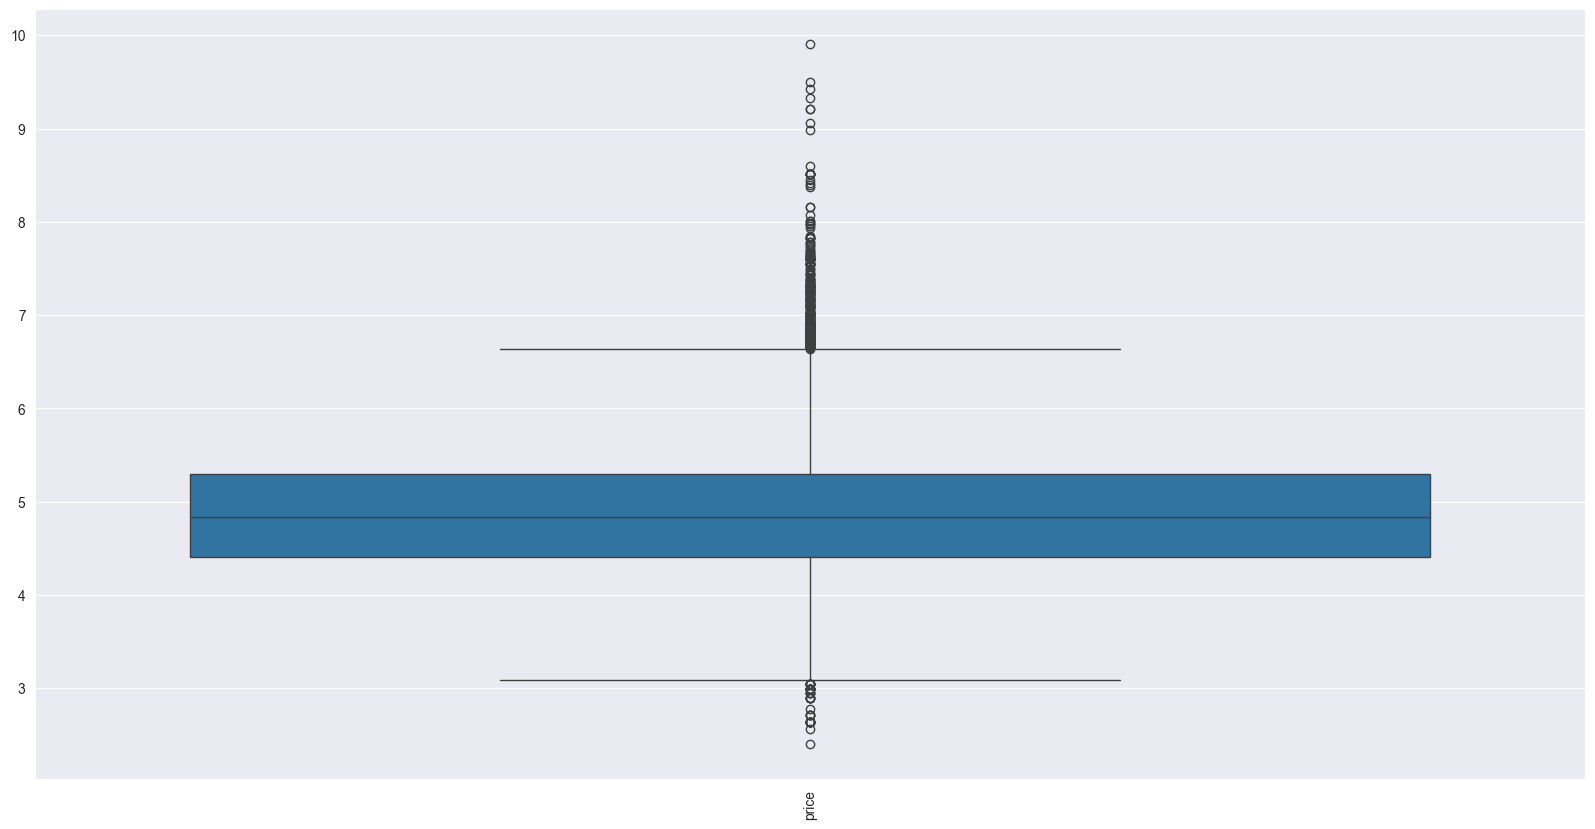

In [171]:
# Checking for outliers in price
plt.figure(figsize=(20,10))
sns.boxplot(data=train_features[['price']])
plt.xticks(rotation=90)
plt.show()

Removing or not removing the outliers doesn't change the output much, meaning the models are well equipped to handle outliners

In [172]:
#Handling Outliers using median and IQR 
def outlier(a):
    Q1 = a.quantile(0.25)
    Q3 = a.quantile(0.75)
    IQR = Q3-Q1
    L = Q1 - 1.5*IQR
    U = Q3 + 1.5*IQR
    return(L,U)

# Updating price
train_features = train_features.loc[train_features['price'] >= outlier(train_features['price'])[0]]
train_features = train_features.loc[train_features['price'] <= outlier(train_features['price'])[1]]

# Visualize change
plt.figure(figsize=(5,5))
sns.boxplot(data=train_features[['price']])
plt.xticks(rotation=90)
plt.show()

In [173]:
# Assigning appropriate names to training and resting data
X_train = train_features.drop(['price'], axis=1)
y_train = train_features['price']
X_test = test_features.drop(['price'], axis=1)
y_test = test_features['price']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33288, 231), (8284, 211), (33288,), (8284,))

In [174]:
# Aligning column discrepancy due to separating amenities. Important step.
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33288, 206), (8284, 206), (33288,), (8284,))

##### Feature Importance

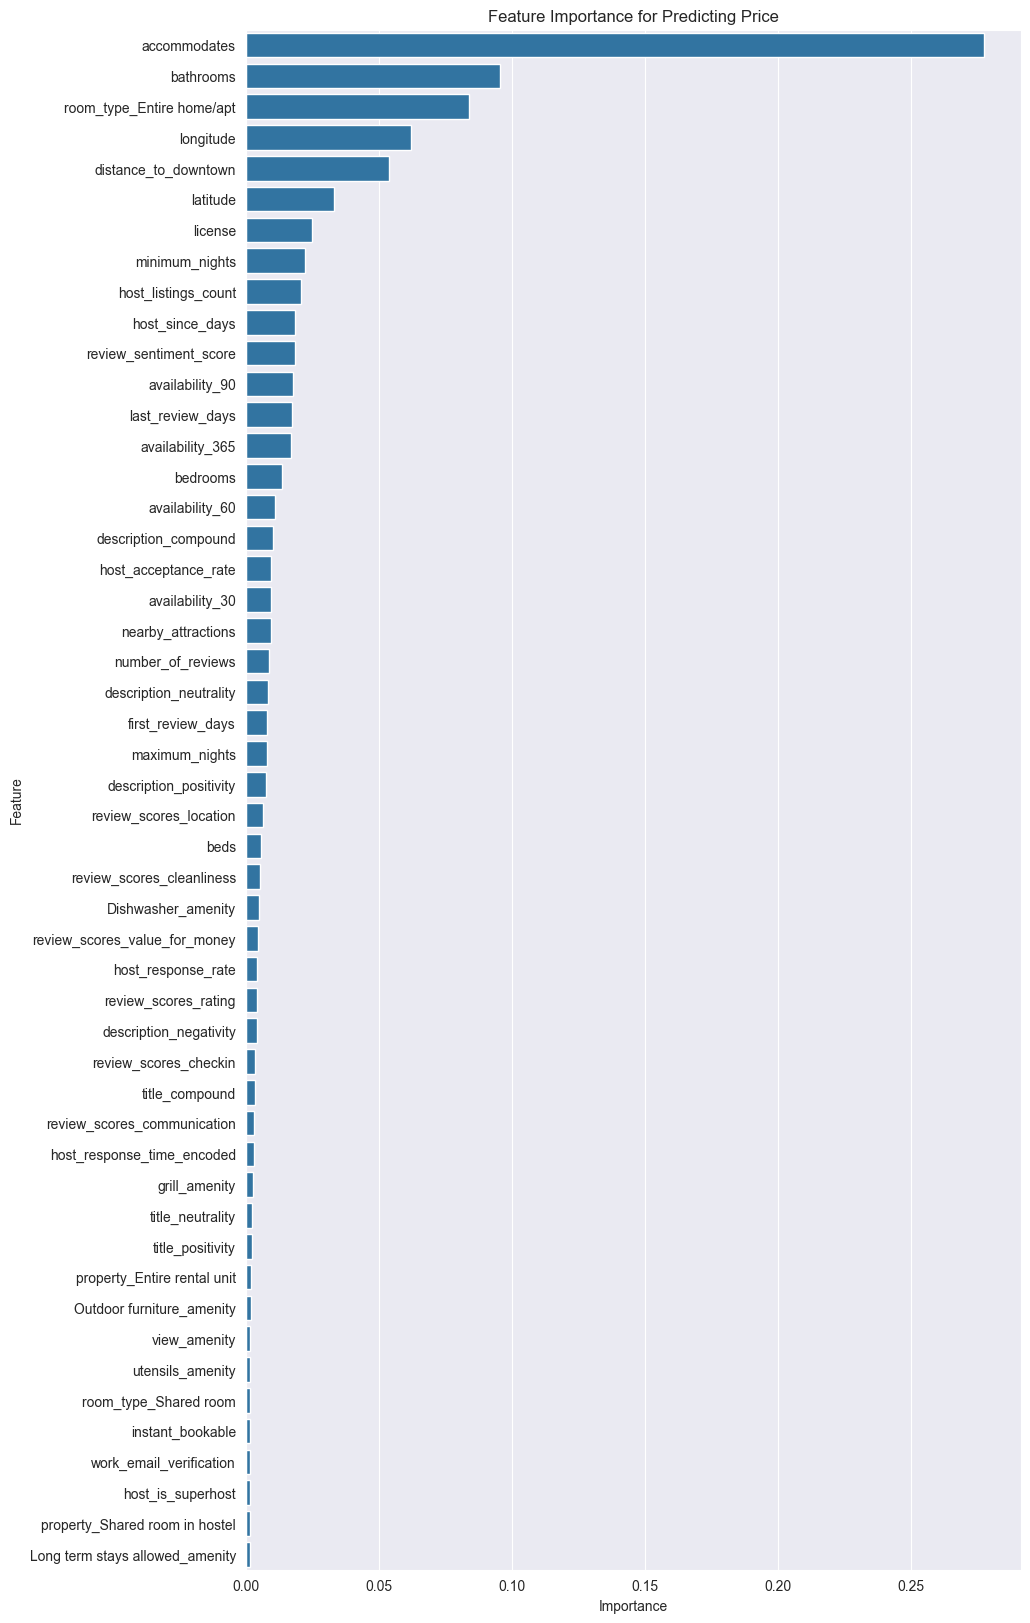

In [175]:
#Train a Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Extract feature importance
feature_importance = model_rf.feature_importances_

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 20))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(50))
plt.title('Feature Importance for Predicting Price')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [176]:
# Display all features with zero importance
zero_importance_features = feature_importance_df[feature_importance_df['Importance'] == 0]
print(zero_importance_features)

                           Feature  Importance
192                bedding_amenity         0.0
137            smoke_alarm_amenity         0.0
117              hot_water_amenity         0.0
196      cleaning products_amenity         0.0
134                 sports_amenity         0.0
124             ev_charger_amenity         0.0
125                hammock_amenity         0.0
127               elevator_amenity         0.0
35                has_host_picture         0.0
34                     has_picture         0.0
189              first_aid_amenity         0.0
155                bathtub_amenity         0.0
187       private_entrance_amenity         0.0
186           pets_allowed_amenity         0.0
159                laundry_amenity         0.0
161               fire pit_amenity         0.0
152           lock_on_door_amenity         0.0
164           sound_system_amenity         0.0
165  Children’s dinnerware_amenity         0.0
129          self_checking_amenity         0.0
168          

In [177]:
# Converting to list
zero_importance_features_list = zero_importance_features['Feature'].tolist()

# Removing features with 0 importance
X_train = X_train.drop(columns=zero_importance_features_list)
X_test = X_test.drop(columns=zero_importance_features_list)

In [178]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

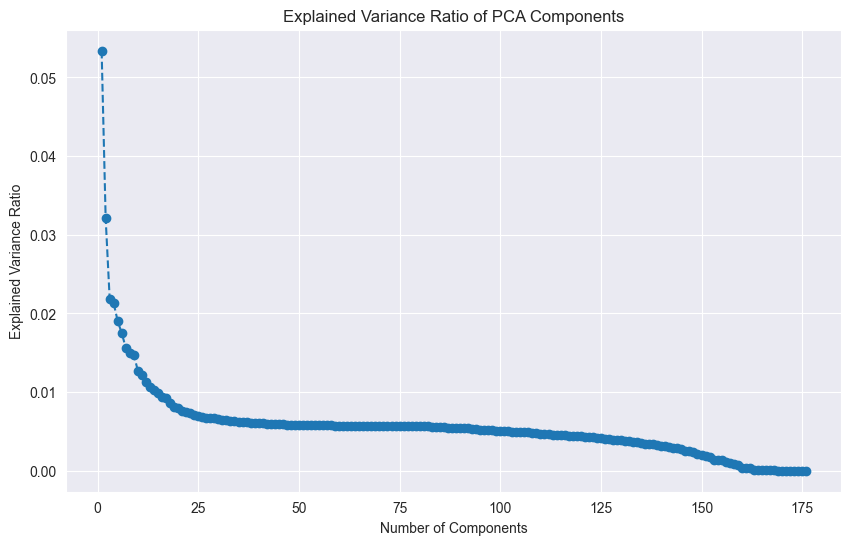

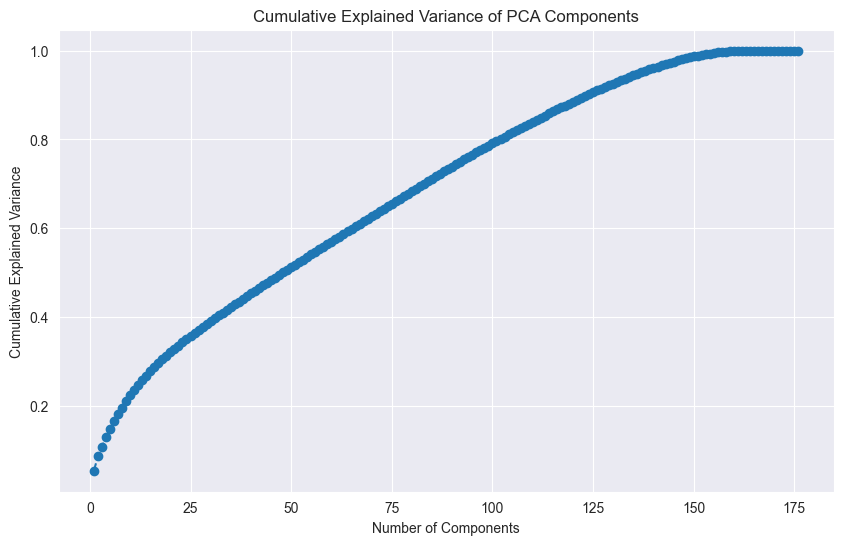

Cumulative Explained Variance Ratio:
Components: 1, Cumulative Explained Variance: 0.0534
Components: 2, Cumulative Explained Variance: 0.0855
Components: 3, Cumulative Explained Variance: 0.1073
Components: 4, Cumulative Explained Variance: 0.1285
Components: 5, Cumulative Explained Variance: 0.1475
Components: 6, Cumulative Explained Variance: 0.1650
Components: 7, Cumulative Explained Variance: 0.1806
Components: 8, Cumulative Explained Variance: 0.1956
Components: 9, Cumulative Explained Variance: 0.2103
Components: 10, Cumulative Explained Variance: 0.2231
Components: 11, Cumulative Explained Variance: 0.2353
Components: 12, Cumulative Explained Variance: 0.2466
Components: 13, Cumulative Explained Variance: 0.2572
Components: 14, Cumulative Explained Variance: 0.2674
Components: 15, Cumulative Explained Variance: 0.2773
Components: 16, Cumulative Explained Variance: 0.2867
Components: 17, Cumulative Explained Variance: 0.2959
Components: 18, Cumulative Explained Variance: 0.3045


In [179]:
# Initialize PCA
pca = PCA()

# Fit PCA on the scaled features
pca.fit(X_train_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, X_train_scaled.shape[1] + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of PCA Components')
plt.grid(True)
plt.show()

# Plot cumulative explained variance ratio
cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, X_train_scaled.shape[1] + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance of PCA Components')
plt.grid(True)
plt.show()

# Print the cumulative explained variance ratio
print("Cumulative Explained Variance Ratio:")
for i, variance in enumerate(cumulative_variance):
    print(f"Components: {i + 1}, Cumulative Explained Variance: {variance:.4f}")

## Model Building

##### Linear Regression

Reducing Dimensionality with PCA

In [180]:
# Initialize PCA with desired number of components
pca = PCA(n_components=137) # Using Cumulative Explained Variance of 95%

# Fit PCA and transform the features
train_pca = pca.fit_transform(X_train_scaled)
test_pca = pca.transform(X_test_scaled)

Building and evaluating linear regression model

In [181]:
# Linear Regression
model_linear = LinearRegression()
# Training the model
model_linear.fit(train_pca, y_train)

# Predicting the price
y_pred_linear = model_linear.predict(test_pca)

# Evaluate Linear Regression
linearr2 = r2_score(y_test, y_pred_linear)
linearmae = mean_absolute_error(y_test, y_pred_linear)
linearmse = mean_squared_error(y_test, y_pred_linear)
linearrmse = np.sqrt(linearmse)

# Calculating and printing the evaluation metrices values
print(f'Linear Regression Fitting:')
print(f'R2 Score: {linearr2}') # How well the variation in target variable is successfully defined by variation in input features.
print(f'MAE: {linearmae}') # Best when there are many outliers
print(f'MSE: {linearmse}') # Best when there are less outliers
print(f'RMSE: {linearrmse}')

Linear Regression Fitting:
R2 Score: 0.5963926718792647
MAE: 0.33304572982069686
MSE: 0.1999949020660906
RMSE: 0.4472078958002537


##### Ridge

Identifying ideal hyperparameter value

In [182]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Expand the range of alphas
alphas = logspace(-3, 2, 50)  # This will generate 200 values from 10^-6 to 10^1

# Initialize the model with expanded alphas range
model = RidgeCV(alphas=alphas, cv=cv, scoring='neg_mean_absolute_error')
# Training the model
model.fit(X_train_scaled, y_train)

# summarize chosen configuration
print('alpha: %f' % model.alpha_)

alpha: 2.947052


Building and evaluating ridge model

In [183]:
# Ridge Regression

model_ridge = Ridge(alpha=2.32, random_state=42)
# Training the model
model_ridge.fit(X_train, y_train)

# Predicting the price
y_pred_ridge = model_ridge.predict(X_test)

# Evaluate Ridge Regression
ridger2 = r2_score(y_test, y_pred_ridge)
ridgemse = mean_squared_error(y_test, y_pred_ridge)

# Calculating and printing the evaluation metrices values
print(f'Ridge Regression Fitting:')
print(f'R2 Score: {ridger2}')
print(f'MSE: {ridgemse}')

Ridge Regression Fitting:
R2 Score: 0.6212357636726434
MSE: 0.18768469022387796


##### Light GBM

Determining appropriate parameter grid

In [184]:
# # Define the parameter grid to test
# param_grid = {
#     'num_leaves': [31, 50, 100, 200],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 500, 1000, 3000]
# }
# 
# # Initialize the model
# model_lgbm = lgb.LGBMRegressor()
# 
# # Grid search
# grid_search = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train_scaled, y_train)
# 
# # Best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# 
# print(f"Best Parameters: {best_params}")
# print(f"Best Score: {best_score}")

In [185]:
# Train the final model with the best parameters
final_model_lgbm = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=3000, num_leaves=200, verbose=0, max_depth=-1, random_state=42)
final_model_lgbm.fit(X_train_scaled, y_train)
y_pred_gbm = final_model_lgbm.predict(X_test_scaled)

# Evaluate Light GBM
lgbmr2 = r2_score(y_test, y_pred_gbm)
lgbmmse = mean_squared_error(y_test, y_pred_gbm)

# Calculating and printing the evaluation metrices values
print(f'Light GBM Fitting:')
print(f'R2 Score: {lgbmr2}')
print(f'MSE: {lgbmmse}')

Light GBM Fitting:
R2 Score: 0.7641337644961523
MSE: 0.1168760856992626


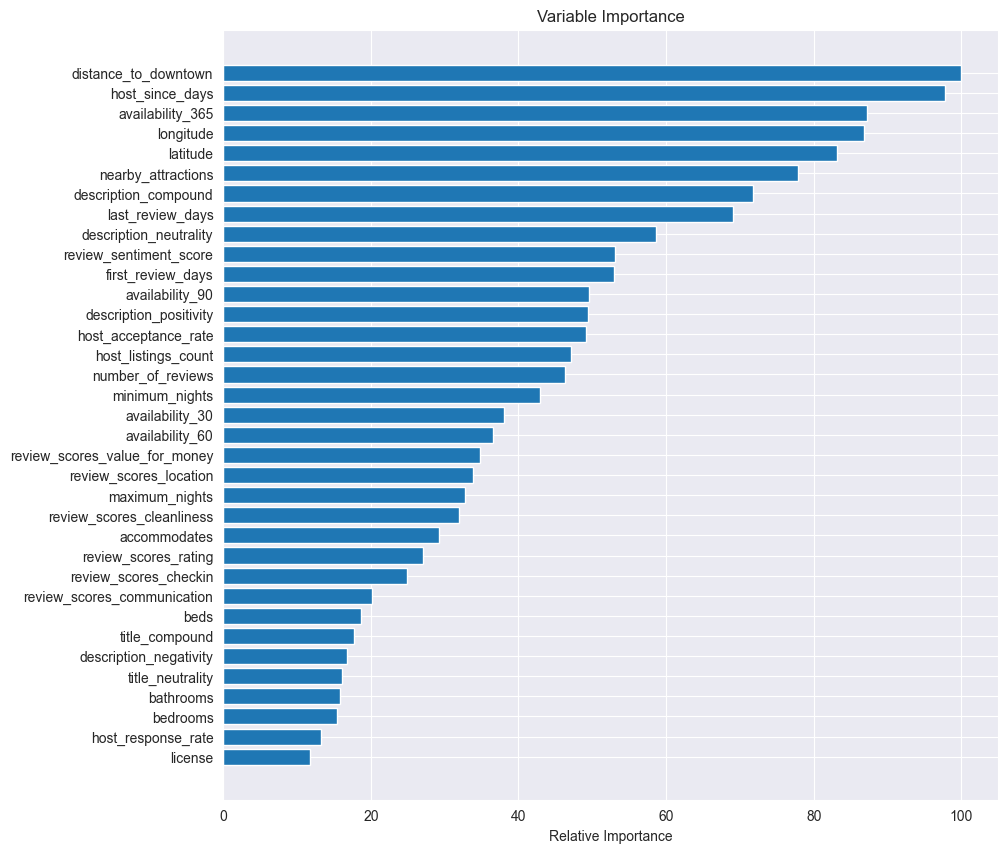

In [189]:
# Plot feature importance
top = 35
feature_importance = final_model_lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (10,10))
plt.barh(pos[-top:], feature_importance[sorted_idx][-top:], align='center')
plt.yticks(pos[-top:], X_train.columns[sorted_idx][-top:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

##### XG Boost

In [187]:
model_xgb = xgb.XGBRegressor(learning_rate=0.04, max_depth=10, min_child_weight=2, n_estimators=1500, seed=25)
model_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Evaluate Light GBM
xgbr2 = r2_score(y_test, y_pred_xgb)
xgbmse = mean_squared_error(y_test, y_pred_xgb)

# Calculating and printing the evaluation metrices values
print(f'XG Boost Fitting:')
print(f'R2 Score: {xgbr2}')
print(f'MSE: {xgbmse}')

Light GBM Fitting:
R2 Score: 0.7574250819827242
MSE: 0.12020036206588053


##### Random Forest Regressor

In [190]:
y_pred_rf = model_rf.predict(X_test)

# Evaluate Light GBM
rfr2 = r2_score(y_test, y_pred_rf)
rfmse = mean_squared_error(y_test, y_pred_rf)

# Calculating and printing the evaluation metrices values
print(f'Random Forest Regressor Fitting:')
print(f'R2 Score: {rfr2}')
print(f'MSE: {rfmse}')

Light GBM Fitting:
R2 Score: 0.7236399240377025
MSE: 0.13694153320854313


#### Comparing the performance of different models

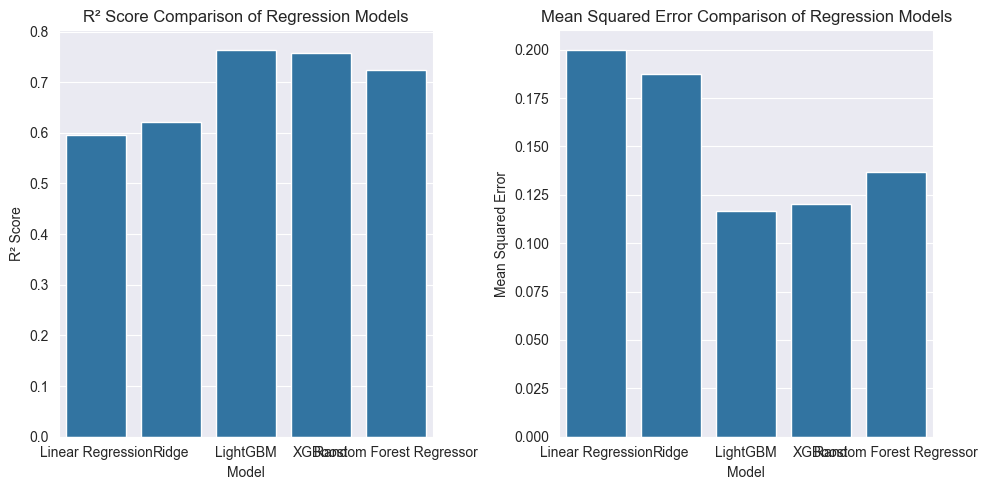

R² Scores:
                     Model  R² Score
0        Linear Regression  0.596393
1                    Ridge  0.621236
2                 LightGBM  0.764134
3                  XGBoost  0.757425
4  Random Forest Regressor  0.723640

Mean Squared Errors:
                     Model       MSE
0        Linear Regression  0.199995
1                    Ridge  0.187685
2                 LightGBM  0.116876
3                  XGBoost  0.120200
4  Random Forest Regressor  0.136942


In [196]:
# Create a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'LightGBM', 'XGBoost', 'Random Forest Regressor'],
    'R² Score': [linearr2, ridger2, lgbmr2, xgbr2, rfr2],
    'MSE': [linearmse, ridgemse, lgbmmse, xgbmse, rfmse]
})

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot R² scores
sns.barplot(ax=axes[0], x='Model', y='R² Score', data=results_df)
axes[0].set_title('R² Score Comparison of Regression Models')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R² Score')

# Plot MSE
sns.barplot(ax=axes[1], x='Model', y='MSE', data=results_df)
axes[1].set_title('Mean Squared Error Comparison of Regression Models')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()

# Print the results for quick reference
print("R² Scores:")
print(results_df[['Model', 'R² Score']])

print("\nMean Squared Errors:")
print(results_df[['Model', 'MSE']])